# Summary Order 2 order 1

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : June 4th  2022
- last update : June 4rd 2022 : Save in file

### 


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,10)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

from astropy import units as u

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [32]:
import seaborn as sns

In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from datetime import datetime,date

In [5]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [6]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [7]:
string_date

'2022-06-04'

In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.8.4'

In [10]:
from astropy.io import fits
from scipy import interpolate
from scipy.signal import savgol_filter

In [11]:
from time import sleep

In [12]:
from astropy.time import Time
import astropy.units as u

# Input file

/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/postISRCCD/BG40~holo4_003/config_DECONVOLUTION_PSF1D/20211104/2021110400508/basespec

In [13]:
path = "data_order21"

In [18]:
filelist = sorted(os.listdir(path))
filelist

['order2order1_2021110400263.csv',
 'order2order1_2021110400274.csv',
 'order2order1_2021110400508.csv',
 'order2order1_2021110400519.csv',
 'order2order1_2021110400542.csv',
 'order2order1_2021110400553.csv',
 'order2order1_2021110400564.csv']

In [33]:
N=len(filelist)

In [22]:
exposure_list = [ (filename.split(".")[0]).split("_")[-1]  for filename in filelist ]

In [23]:
exposure_list

['2021110400263',
 '2021110400274',
 '2021110400508',
 '2021110400519',
 '2021110400542',
 '2021110400553',
 '2021110400564']

In [15]:
#exposure = "2021110400263"  # HD905205
#exposure = "2021110400274"  # HD009051 , creazy results
#exposure = "2021110400508"  # ETADOR
#exposure = "2021110400519"  # HD38949
#exposure = "2021110400542"  # HD031128
#exposure = "2021110400553"  # Mu Col
#exposure = "2021110400564"  # HD38949

In [20]:
Exposure_to_target = {"2021110400263":"HD905205",
                     "2021110400274":"HD009051",
                     "2021110400508":"ETADOR",
                     "2021110400519":"HD38949",
                     "2021110400542":"HD031128",
                     "2021110400553":"Mu Col",
                     "2021110400564":"HD38949"}                     


In [25]:
all_df = [  pd.read_csv(os.path.join(path,filename)) for filename in filelist]

(0.0, 5.0)

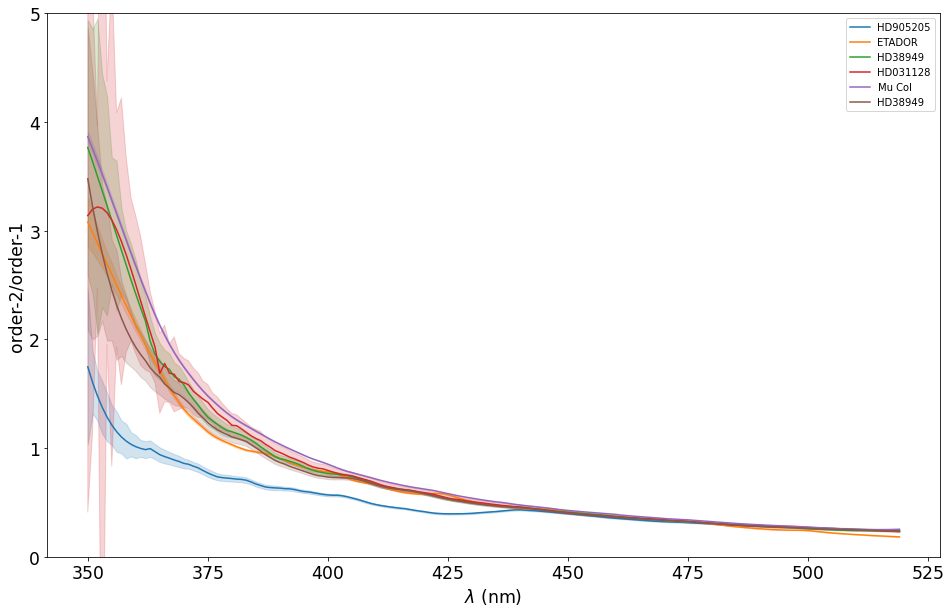

In [38]:
sns.color_palette("hls", N)
fig=plt.figure()
ax=fig.add_subplot(111)

for count,df in enumerate(all_df):
    wl    = df["lambdas"] 
    ratio = df["ratioo2o1"] 
    ratioerr = df["ratioo2o1err"]
    exposure = exposure_list[count]
    target   = Exposure_to_target[exposure] 
    if count != 1:
        c=ax.plot(wl,ratio,label=target,lw)
        ax.fill_between(wl, ratio-ratioerr , ratio + ratioerr,color=c[0].get_color(), alpha=0.2)
    
   
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("order-2/order-1")
ax.legend()
ax.set_ylim(0,5.)
    

In [ ]:
c.